In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Setup logging with some hacks to work in the notebook.
import logging
import sys

logger = logging.getLogger()
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)

import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import keras.backend as K
from keras.metrics import binary_crossentropy
from math import sqrt
from skimage.transform import resize

import sys; sys.path.append('../')
from src.models.unet_jocic import UNet
from src.utils.runtime import gpu_selection
from src.utils.data import random_transforms
from src.utils.model import dice_coef, jaccard_coef

gpu_selection(visible_devices='3')

logger.info('Done')

Using TensorFlow backend.
Done


In [2]:
%%time

model = UNet()
exp = 80  ###
model.load_config('checkpoints/{}/{}.config'.format(exp, exp))

model.checkpoint_name = 'checkpoints/{}/{}'.format(exp, exp)
chkpt_name = model.checkpoint_name

# use 512 when predict
model.config['input_shape'] = model.config['img_shape'] + model.config['input_shape'][-1:]
model.config['output_shape'] = model.config['img_shape'] + model.config['output_shape'][-1:]
model.config['output_shape_onehot'] = model.config['img_shape'] + model.config['output_shape_onehot'][-1:]

model.compile()
# model.net.summary()
model.net.load_weights('checkpoints/{}/{}_val_loss.net'.format(exp, exp))  ### trn val

img_stack = tiff.imread('data/test-volume.tif')  ###  train test
X_batch, coords = model.batch_gen_submit(img_stack)
prd_batch = model.net.predict(X_batch, batch_size=model.config['batch_size'])

prd_stack = np.empty(img_stack.shape)
for prd_wdw, (img_idx, y0, y1, x0, x1) in zip(prd_batch, coords):
    prd_stack[img_idx, y0:y1, x0:x1] = prd_wdw.reshape(y1 - y0, x1 - x0)
prd_stack = prd_stack.astype('float32')

tiff.imsave(chkpt_name + '.submission.tif', prd_stack)

CPU times: user 4.44 s, sys: 1.18 s, total: 5.61 s
Wall time: 6.26 s


In [9]:
"""save the valid part and use ImageJ script to give 5 metrics value
"""
gt_lb = tiff.imread('data/train-labels.tif')
pred_lb = tiff.imread('checkpoints/{}/{}.submission.tif'.format(exp, exp))

# idx = [15, 12, 2, 11, 27, 23, 28, 25, 4, 26]
idx = range(0,10,1)

tiff.imsave('gt.tif', gt_lb[idx])
tiff.imsave('pred.tif', pred_lb[idx])

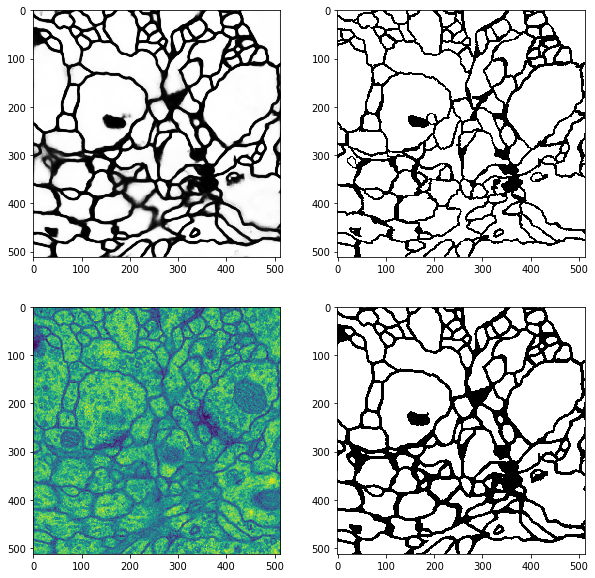

In [4]:
ori = tiff.imread('data/train-volume.tif')

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0][0].imshow(pred_lb[0], cmap='gray')
ax[0][1].imshow(gt_lb[0], cmap='gray')
ax[1][0].imshow(ori[0])
ax[1][1].imshow(np.round(pred_lb[0]), cmap='gray')


In [ ]:
import numpy as np

def dice_coef(y_true, y_pred, smooth=1):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

dice_coef(pred_lb[0], gt_lb[0]/255)

In [10]:
lb = tiff.imread('data/train-labels.tif') / 255
ratio = np.sum(lb.astype('uint8')) / (30*512*512)
print(ratio)

0.7803688049316406


In [ ]:
import pickle

checkpoint_path = 'checkpoints/001/unet_21_256.config'
f = open(checkpoint_path, 'rb')
config = pickle.load(f)
f.close()

config

original size: (512, 512)


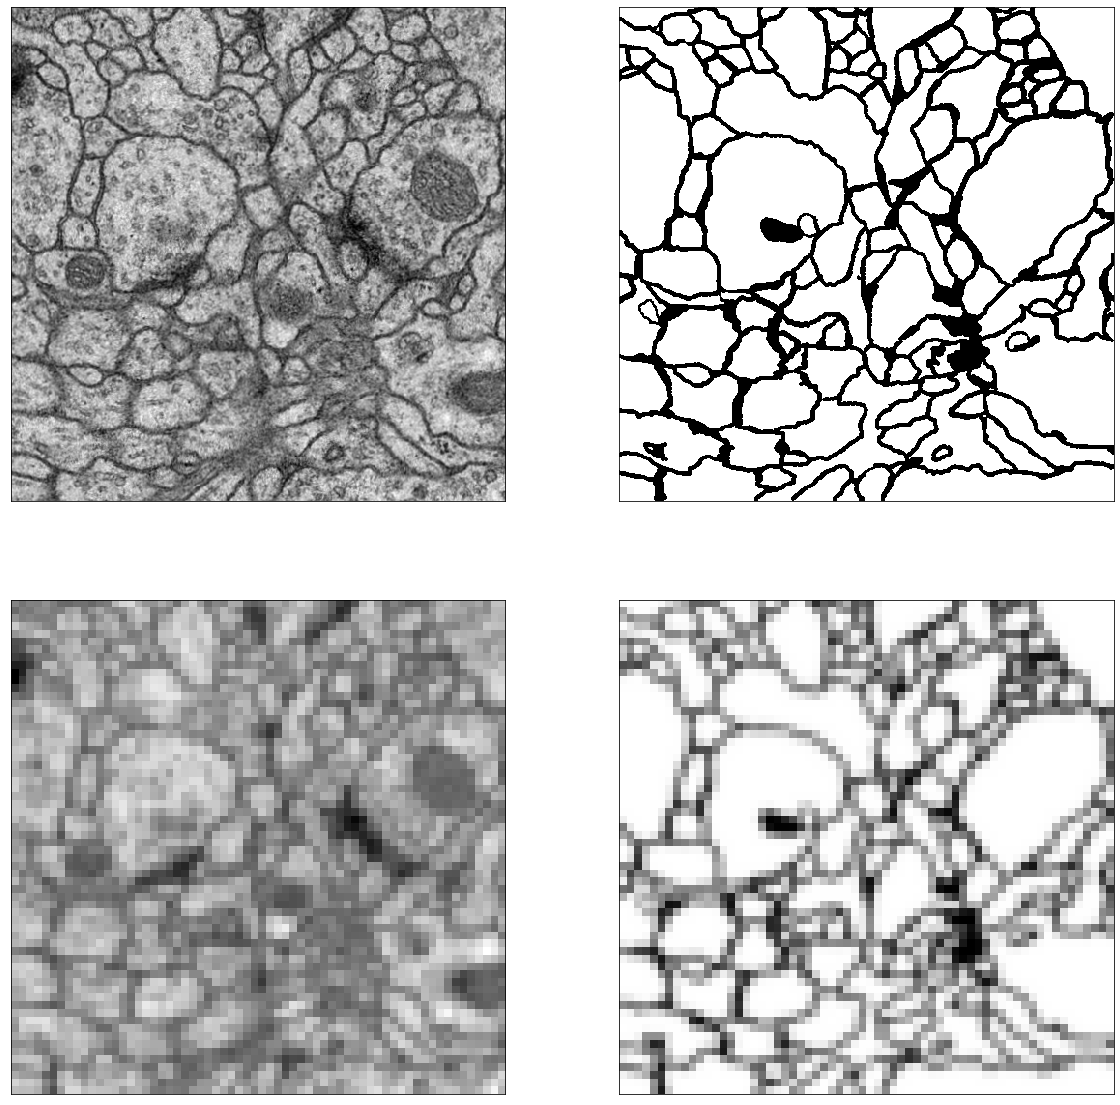

In [3]:
"""check downsampling/resize effect on cell images
512-256-128-64-32
32 is very bad
"""

imgs = tiff.imread('data/train-volume.tif')
img = imgs[0]
annots = tiff.imread('data/train-labels.tif')
annot = annots[0]

from skimage.transform import resize

print("original size: {}".format(img.shape))
r_shape = 64 
img_2 = resize(img, (r_shape, r_shape))
annot_2 = resize(annot, (r_shape, r_shape))

fig, ax = plt.subplots(2,2, figsize=(20,20))
for a1 in ax:
    for a in a1:
        a.set_xticks([])
        a.set_yticks([])
ax[0][0].imshow(img, cmap='gray')
ax[0][1].imshow(annot, cmap='gray')
ax[1][0].imshow(img_2, cmap='gray')
ax[1][1].imshow(annot_2, cmap='gray')
